### Intro

In this notebook you can play with a combinatorial optimization problem we solve with CappedIGW. This example is not described in the original paper, but shows the potential for CappedIGW for in-context learning with LLM models.

In the notebook below we define a reference policy and a loss predictor for this dataset. To use CappedIGW this is all you have to define. The rest of the algorithm can be treated as a black box.

For the reference policy below we use embeddings from a transformer to calculate similarity scores. We then sample from a softmax distribution of the similarity ranking using a Gumbel distribution.

A quick note, throughout the notebook we use [Coba](https://github.com/VowpalWabbit/coba) to orchestrate our experiments and record their results. It is not necessary to learn about or use coba to understand and utilize CappedIGW beyond this notebook.

# Install Dependencies

In [ ]:
%pip install torch --quiet --quiet
%pip install coba --quiet --quiet
%pip install scipy --quiet --quiet
%pip install numpy --quiet --quiet
%pip install matplotlib --quiet --quiet
%pip install cloudpickle --quiet --quiet
%pip install sentence-transformers --quiet --quiet
%pip install ipywidgets --quiet --quiet

## Definitions

In [1]:
import warnings
import json
from collections import defaultdict
from typing import Sequence, Callable

import torch
import coba as cb
from sentence_transformers import SentenceTransformer

from AbstractClasses import ReferencePolicy, LossPredictor

model = SentenceTransformer('all-MiniLM-L6-v2')

def embedder(items,device=None):
    if not isinstance(items,(str,list)):
        raise AssertionError()
    if isinstance(items,str):
        items = [items]
    elif isinstance(items,list):
        items = [ i['instruction'] for i in items]

    embeddings = model.encode(items,convert_to_tensor=True).to(device=device)
    normalized = torch.nn.functional.normalize(embeddings)

    return normalized

def taskid(item):
    text = item if isinstance(item,str) else item['instruction']
    return 'first' if 'first' in text else 'second' if 'second' in text else 'last'

class RandomizedSimilarity(ReferencePolicy):
    def __init__(self, 
        embedder: Callable, 
        examples: Sequence, 
        ex_embeddings: Sequence, 
        batch_size: int, 
        temperature:float,
        set_size:int,
        stratum: Callable = lambda item: 1,
        preselect:int = 500) -> None:
        self._embedder = embedder
        self._batch_size = batch_size
        self._temperature = temperature
        self._set_size = set_size
        self._stratum = stratum
        self._preselect = preselect

        self._strata_examples = defaultdict(list)
        self._strata_embeddings = defaultdict(list)
        for example,embedding in zip(examples,ex_embeddings):
            self._strata_examples[stratum(example)].append(example)
            self._strata_embeddings[stratum(example)].append(embedding)
        self._strata_examples.default_factory = None
        self._strata_embeddings.default_factory = None

        for stratum,embeddings in self._strata_embeddings.items():
            self._strata_embeddings[stratum] = torch.stack(embeddings)

    @property
    def params(self):
        return {'temp':self._temperature, 'sampler':'RandomizedSimilarity', 'n_strata':len(self._strata_examples)}
    
    def sample(self, context):
        with torch.no_grad():
            context_stratum = self._stratum(context)
    
            embeddings = self._strata_embeddings[context_stratum]
            examples   = self._strata_examples[context_stratum]
            
            embedded_context = self._embedder(context)
            all_similarities = embedded_context @ embeddings.T
            top_similarities = torch.topk(all_similarities,k=self._preselect)
            similarities     = top_similarities.values
            original_indices = top_similarities.indices
            
            gumbel = torch.distributions.gumbel.Gumbel(0,1)
            gumbel_shape = torch.Size([self._batch_size, similarities.shape[1]])

            while True:
                gumbels = gumbel.sample(gumbel_shape)*self._temperature
                topks   = torch.topk(similarities+gumbels,self._set_size,dim=1).indices
                
                yield [ [ (examples[original_indices[0,i]],similarities[0,i].item()) for i in row] for row in topks ]

class MyLossPredictor(LossPredictor):
    class LogisticRegressor(torch.nn.Module):
        def __init__(self, in_features:int):
            super().__init__()
            self.linear  = torch.nn.Linear(in_features=in_features, out_features=1)
            self.sigmoid = torch.nn.Sigmoid()

        @property
        def params(self):
            return {'type':'logistic'}
    
        def pre_logits(self, X):
            return self.linear(X)

        def predictions(self, X):
            return self.sigmoid(self.pre_logits(X))

    def __init__(self, *, set_size:int, opt_factory, sched_factory, params={}) -> None:
        self._regressor = MyLossPredictor.LogisticRegressor(4*set_size)
        self.loss       = torch.nn.BCEWithLogitsLoss(reduction='none')
        self.opt        = opt_factory(self._regressor.parameters())
        self.scheduler  = sched_factory(self.opt)
        self.y_sum      = 0
        self.t          = 0
        self._params    = params

    @property
    def params(self):
        return {**self._regressor.params, **self._params}

    def _features(self,x,a):
        features = []
        for e in a:
            i = e[0]['instruction']

            x_task = 'first' if 'first' in x else 'second' if 'second' in x else 'last'
            e_task = 'first' if 'first' in i else 'second' if 'second' in i else 'last'

            x_name = x[x.find('"')+1:x.rfind('"')]
            e_name = i[i.find('"')+1:i.rfind('"')]

            x_first,x_last = x_name.split(' ')
            e_first,e_last = e_name.split(' ')

            same_task  = int(x_task==e_task)
            same_first = int(x_first==e_first)
            same_last  = int(x_last==e_last)
            similarity = e[1]

            features.extend([same_task,same_first,same_last,similarity])
        return features

    def predict(self, context: str, actions) -> Sequence[float]:
        with torch.no_grad():
            X = torch.tensor([ self._features(context,action) for action in actions])
            return self._regressor.predictions(X)

    def learn(self, contexts: torch.Tensor, actions: Sequence[float], losses: Sequence[float]) -> None:
        self.t += 1
        
        with torch.no_grad():
            X = torch.tensor([self._features(context,action) for context,action in zip(contexts,actions)])            
            y = torch.tensor(losses).float()
            self.y_sum += torch.mean(y).item()
        
        self.opt.zero_grad()
        yhat = self._regressor.pre_logits(X).squeeze(1)
        loss = self.loss(yhat,y)
        loss.mean().backward()

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            self.opt.step()
            self.scheduler.step()

        with torch.no_grad():
            y_av = self.y_sum/self.t
            best_const_loss = 0 if y_av <= 0 or y_av >= 1 else self.loss(torch.logit(y_av*torch.ones_like(y)),y)
            cb.CobaContext.learning_info['loss_prediction_loss'] = loss.tolist()
            cb.CobaContext.learning_info['loss_prediction_regret'] = (loss-best_const_loss).tolist()

class FewShotFixedStrategy:
    def __init__(self, sampler:ReferencePolicy) -> None:
        self._sampler = sampler
    @property
    def params(self):
        return self._sampler.params
    def predict(self, context, actions):
        if isinstance(context,cb.Batch): raise Exception()
        action, prob = next(self._sampler.sample(context))[0],None
        return action, prob
    def learn(self, context, actions, action, reward, probs, **kwargs):
        pass

class ZeroShotStrategy:
    def predict(self, context, actions):
        if isinstance(context,cb.Batch): raise Exception()
        return [],None
    def learn(self, context, actions, action, reward, probs, **kwargs):
        pass

## Actually Run Demo

Precompute Embeddings and Preload Environment (with llm)

In [2]:
from LetCatEnvironment import LetCatEnvironment
import time

start = time.time()
print('embedding examples ...', end='', flush=True)
with open('LetCatTrain.jsonl',mode='rb') as f:
    examples = [ json.loads(line) for line in f ]
ex_embeddings = embedder(examples)
end= time.time()
print(f' elapsed time {end-start} seconds')

start = time.time()
print('making environment ...', end='', flush=True)
letcat = LetCatEnvironment()
end= time.time()
print(f' elapsed time {end-start} seconds')

embedding examples ... elapsed time 148.27424216270447 seconds
making environment ... elapsed time 6.468153238296509 seconds


Run Baselines

2023-07-25 07:35:16 -- Experiment Started
2023-07-25 07:35:16 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-07-25 07:35:16 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2023-07-25 07:35:16 -- Recording Learner 1 parameters... (0.0 seconds) (completed)
2023-07-25 07:35:16 -- Recording Learner 2 parameters... (0.0 seconds) (completed)
2023-07-25 07:35:16 -- Recording Learner 3 parameters... (0.0 seconds) (completed)
2023-07-25 07:35:16 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2023-07-25 07:35:16 -- Peeking at Environment 0... (0.1 seconds) (completed)
2023-07-25 07:43:56 -- Evaluating Learner 0 on Environment 0... (519.53 seconds) (completed)
2023-07-25 07:43:56 -- Peeking at Environment 0... (0.13 seconds) (completed)
2023-07-25 07:52:47 -- Evaluating Learner 1 on Environment 0... (530.77 seconds) (completed)
2023-07-25 07:52:47 -- Peeking at Environment 0... (0.15 seconds) (completed)
2023-07-25 08:01:30 -- Evaluating L

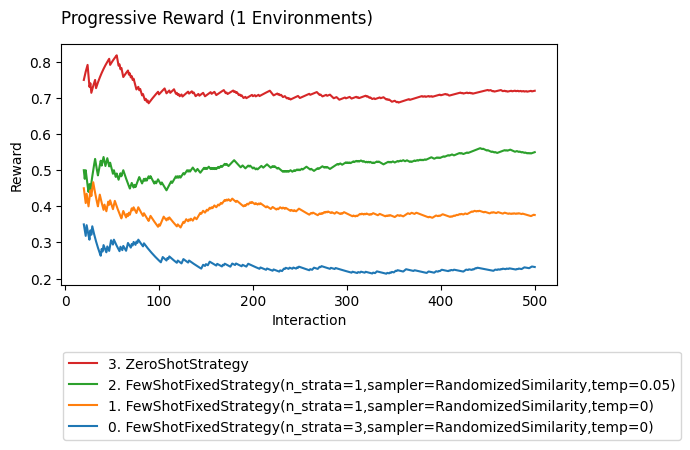

In [3]:
import torch
import coba as cb
from CappedIGW import CappedIGW

batch_size = 4
n_batches = 125

rs_00_1_strat = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=1 , temperature=.00, set_size=3, stratum=taskid)
rs_00_1       = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=1 , temperature=.00, set_size=3)
rs_05_1       = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=1 , temperature=.05, set_size=3)

env = cb.Environments(letcat).take(n_batches*batch_size).batch(batch_size)
lrn = [
    FewShotFixedStrategy(rs_00_1_strat), # skyline
    FewShotFixedStrategy(rs_00_1),       # greedy reference policy (difference from reference policy is overhead of exploration)
    FewShotFixedStrategy(rs_05_1),       # our reference policy
    ZeroShotStrategy(),                  # baseline
]

result = cb.Experiment(env,lrn).run(processes=1)
result.plot_learners(xlim=(20,None))

Run CappedIGW

2023-07-26 09:16:35 -- Experiment Started
2023-07-26 09:16:35 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-07-26 09:16:35 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2023-07-26 09:16:35 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2023-07-26 09:16:35 -- Peeking at Environment 0... (0.14 seconds) (completed)
2023-07-26 10:30:45 -- Evaluating Learner 0 on Environment 0... (4449.28 seconds) (completed)
2023-07-26 10:30:45 -- Experiment Finished


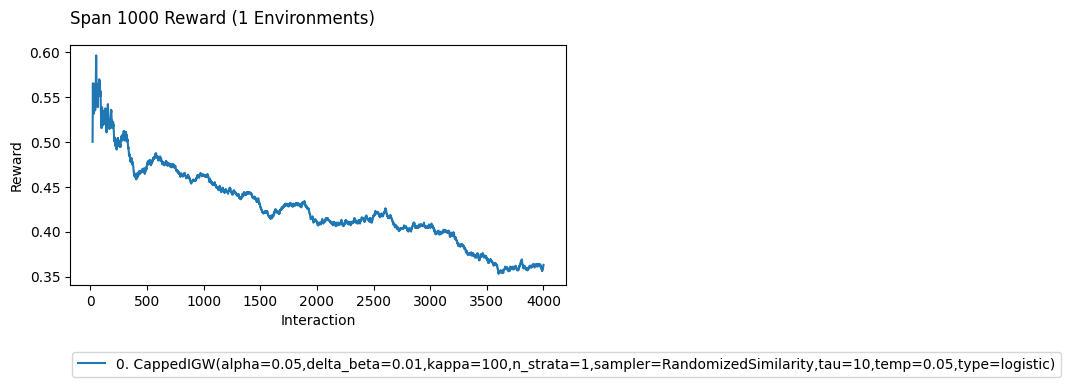

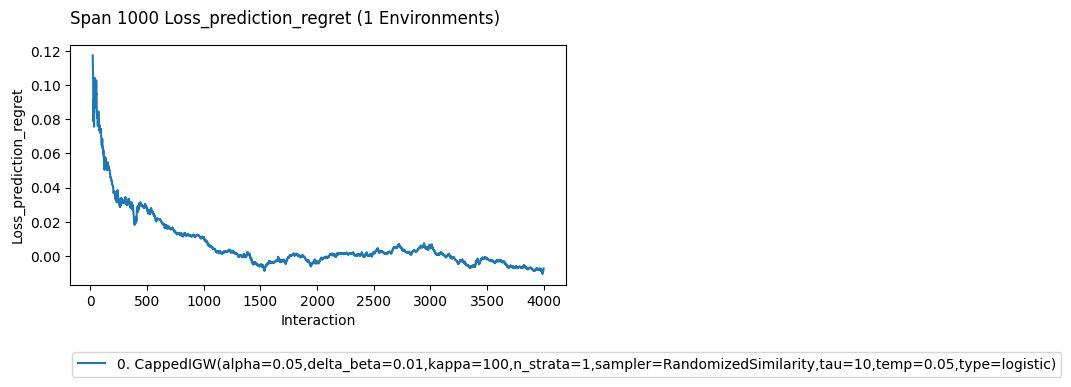

In [3]:
import numpy
import torch
import coba as cb
from LetCatEnvironment import LetCatEnvironment
from CappedIGW import CappedIGW

tzero = 10
gamma_tzero = 1e-4

lr = 1e-1
batch_size = 4
n_batches = 1_000

torch.manual_seed(2112)
numpy.random.seed(45)

rs_05_30      = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=30, temperature=.05, set_size=3)

fhat = MyLossPredictor(
    set_size=3,
    opt_factory=lambda params: torch.optim.Adam(params,lr=lr),
    sched_factory=lambda opt: torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda t:(1+t/tzero)**(-.5))
)

env = cb.Environments(letcat).take(n_batches*batch_size).batch(batch_size)
lrn = [
    CappedIGW(mu=rs_05_30, fhat=fhat, gamma_sched=lambda t: (1 + t/gamma_tzero)**(0.5))
]

result = cb.Experiment(env,lrn).run(processes=1)
result.plot_learners(xlim=(20,None), span=1000)
result.where(learner_id=len(lrn)-1).plot_learners(y='loss_prediction_regret',xlim=(20,None), span=1000)